Predicting Personality Traits from Text
on (**MBTI**) Myers-Briggs Personality Type Dataset


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Dataset/mbti_1.csv')

# --- Create Target Variables ---
# Mind: Introversion (1) / Extraversion (0)
df['is_I'] = df['type'].apply(lambda x: 1 if x[0] == 'I' else 0)
# Energy: Intuition (1) / Sensing (0)
df['is_N'] = df['type'].apply(lambda x: 1 if x[1] == 'N' else 0)
# Nature: Feeling (1) / Thinking (0)
df['is_F'] = df['type'].apply(lambda x: 1 if x[2] == 'F' else 0)
# Tactics: Perceiving (1) / Judging (0)
df['is_P'] = df['type'].apply(lambda x: 1 if x[3] == 'P' else 0)

print("Data Head:")
print(df.head())

Data Head:
   type                                              posts  is_I  is_N  is_F  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...     1     1     1   
1  ENTP  'I'm finding the lack of me in these posts ver...     0     1     0   
2  INTP  'Good one  _____   https://www.youtube.com/wat...     1     1     0   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...     1     1     0   
4  ENTJ  'You're fired.|||That's another silly misconce...     0     1     0   

   is_P  
0     0  
1     1  
2     1  
3     0  
4     0  


The Myers Briggs Type Indicator (or MBTI for short) is a personality type system that divides everyone into 16 distinct personality types across 4 axis:

Introversion (I) – Extroversion (E)

Intuition (N) – Sensing (S)

Thinking (T) – Feeling (F)

Judging (J) – Perceiving (P)

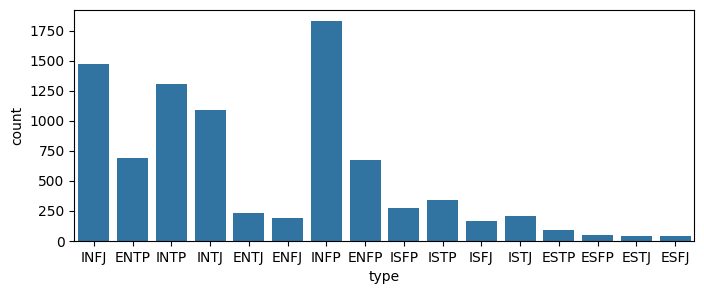

In [18]:
plt.figure(figsize=(8,3))
sns.countplot(x='type', data=df)
plt.show()

<Axes: ylabel='count'>

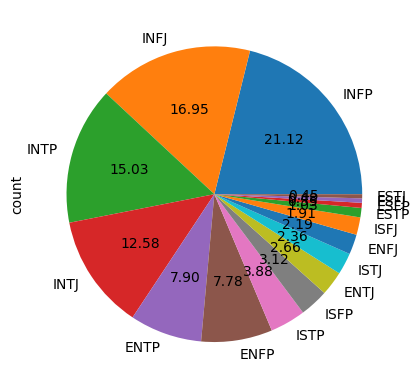

In [19]:
df['type'].value_counts().plot(kind='pie', autopct="%.2f")

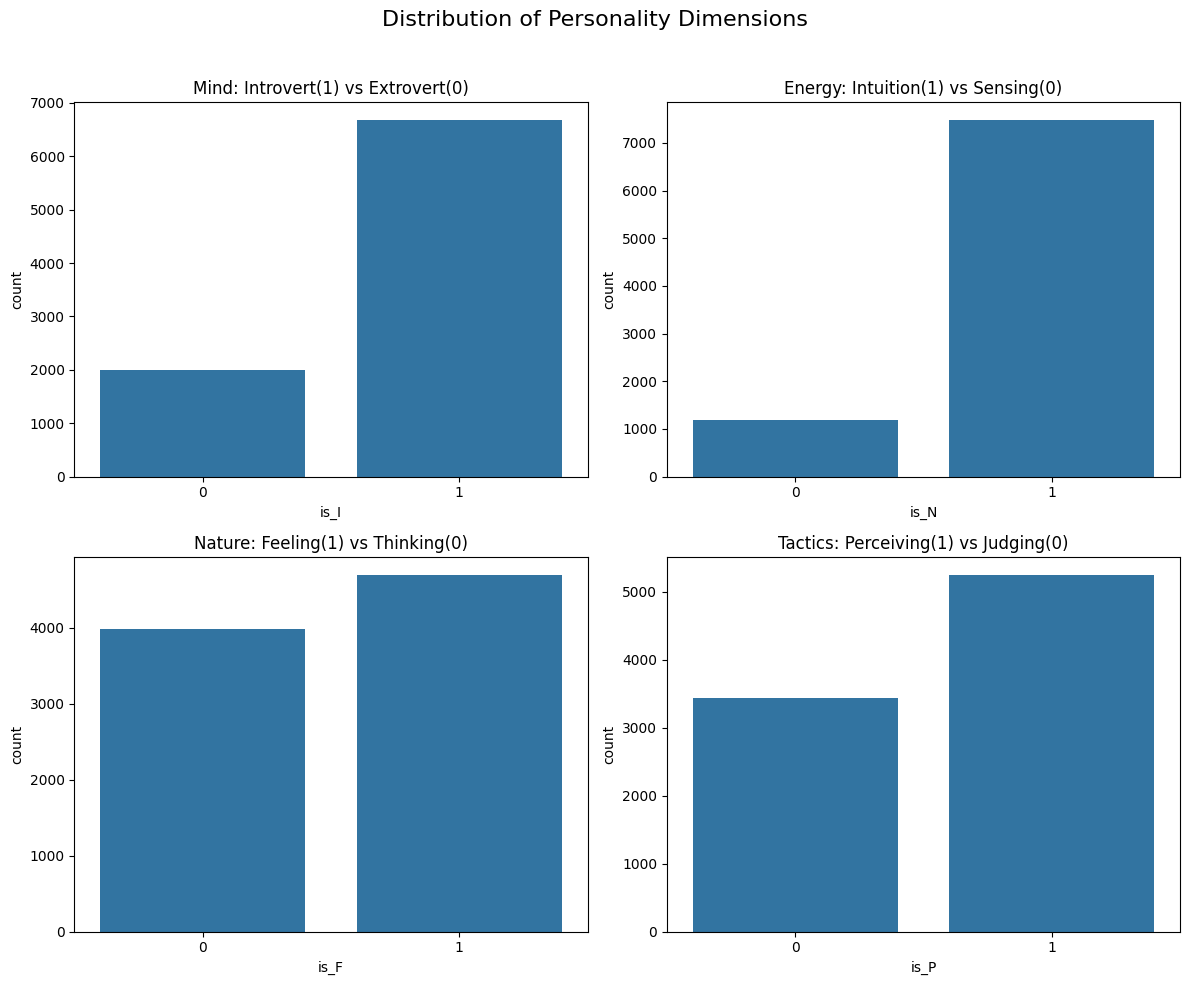

In [20]:
# --- Visualize Class Distribution ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Distribution of Personality Dimensions', fontsize=16)

sns.countplot(x='is_I', data=df, ax=axes[0, 0]).set_title('Mind: Introvert(1) vs Extrovert(0)')
sns.countplot(x='is_N', data=df, ax=axes[0, 1]).set_title('Energy: Intuition(1) vs Sensing(0)')
sns.countplot(x='is_F', data=df, ax=axes[1, 0]).set_title('Nature: Feeling(1) vs Thinking(0)')
sns.countplot(x='is_P', data=df, ax=axes[1, 1]).set_title('Tactics: Perceiving(1) vs Judging(0)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Text Preprocessing**

Raw text from the internet is noisy. We create a cleaning pipeline to standardize the text, removing irrelevant information and preparing it for vectorization.

**The steps are:**

Remove URLs.

Remove special characters and punctuation (keeping only letters and spaces).

Convert all text to lowercase.

Tokenize the text (split into a list of words).

Remove common English "stopwords" (e.g., 'the', 'a', 'is').

Lemmatize words to their root form (e.g., 'walking' becomes 'walk').

In [21]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data (if you haven't already)
# nltk.download('stopwords')
# nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove post separators and non-alphabetic characters
    text = re.sub(r'\|\|\|', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize, lemmatize, and remove stopwords
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(words)

# Apply the cleaning function to the 'posts' column
df['cleaned_posts'] = df['posts'].apply(clean_text)

**Feature Engineering (Vectorization)**

We must convert the cleaned text into a numerical format. We use the TF-IDF (Term Frequency-Inverse Document Frequency) method, which represents each post as a vector of numbers where each number reflects the importance of a word to that post.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

# We will limit the vocabulary to the 5000 most frequent words
MAX_FEATURES = 5000

vectorizer = TfidfVectorizer(max_features=MAX_FEATURES,
                             ngram_range=(1, 2)) # Include bigrams for more context

# Create the feature matrix X
X = vectorizer.fit_transform(df['cleaned_posts'])

**Modeling**

We will train a **LogisticRegression model** for each dimension. Based on our EDA, we know handling class imbalance is critical, so we will use the class_weight='balanced' parameter. This automatically adjusts model penalties to give more weight to the minority class.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# --- Template for Training a Single Dimension Model ---

# 1. Define your target variable (e.g., for Mind dimension)
target_variable = 'is_I'
y = df[target_variable]
class_names = ['Extrovert (E)', 'Introvert (I)'] # For report labeling

# 2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Initialize and train the model
# The key here is class_weight='balanced'
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# 4. Make predictions
y_pred = model.predict(X_test)

# --- Evaluate the Model ---

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for {target_variable}: {accuracy:.3f}\n")

# Generate a detailed classification report
report = classification_report(y_test, y_pred, target_names=class_names)
print(f"Classification Report for {target_variable}:")
print(report)

Accuracy for is_I: 0.844

Classification Report for is_I:
               precision    recall  f1-score   support

Extrovert (E)       0.64      0.73      0.68       400
Introvert (I)       0.92      0.88      0.90      1335

     accuracy                           0.84      1735
    macro avg       0.78      0.80      0.79      1735
 weighted avg       0.85      0.84      0.85      1735



In [24]:
# --- 1. Train the Energy (N/S) Model ---
print("--- Training Energy (N/S) Model ---")
y_ns = df['is_N']
class_names_ns = ['Sensing (S)', 'Intuition (N)']

X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X, y_ns, test_size=0.2, random_state=42, stratify=y_ns)

model_ns = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model_ns.fit(X_train_ns, y_train_ns)

# Evaluate the N/S model
print(classification_report(y_test_ns, model_ns.predict(X_test_ns), target_names=class_names_ns))

--- Training Energy (N/S) Model ---
               precision    recall  f1-score   support

  Sensing (S)       0.56      0.77      0.65       239
Intuition (N)       0.96      0.90      0.93      1496

     accuracy                           0.88      1735
    macro avg       0.76      0.84      0.79      1735
 weighted avg       0.91      0.88      0.89      1735



In [25]:
# --- 2. Train the Nature (F/T) Model ---
print("\n--- Training Nature (F/T) Model ---")
y_ft = df['is_F']
class_names_ft = ['Thinking (T)', 'Feeling (F)']

X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(X, y_ft, test_size=0.2, random_state=42, stratify=y_ft)

model_ft = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model_ft.fit(X_train_ft, y_train_ft)

# Evaluate the F/T model
print(classification_report(y_test_ft, model_ft.predict(X_test_ft), target_names=class_names_ft))


--- Training Nature (F/T) Model ---
              precision    recall  f1-score   support

Thinking (T)       0.82      0.86      0.84       796
 Feeling (F)       0.87      0.84      0.86       939

    accuracy                           0.85      1735
   macro avg       0.85      0.85      0.85      1735
weighted avg       0.85      0.85      0.85      1735



In [26]:
# --- 3. Train the Tactics (J/P) Model ---
print("\n--- Training Tactics (J/P) Model ---")
y_jp = df['is_P']
class_names_jp = ['Judging (J)', 'Perceiving (P)']

X_train_jp, X_test_jp, y_train_jp, y_test_jp = train_test_split(X, y_jp, test_size=0.2, random_state=42, stratify=y_jp)

# For consistency, let's rename the I/E model you already trained
model_ie = model

model_jp = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model_jp.fit(X_train_jp, y_train_jp)

# Evaluate the J/P model
print(classification_report(y_test_jp, model_jp.predict(X_test_jp), target_names=class_names_jp))


--- Training Tactics (J/P) Model ---
                precision    recall  f1-score   support

   Judging (J)       0.75      0.75      0.75       687
Perceiving (P)       0.84      0.84      0.84      1048

      accuracy                           0.80      1735
     macro avg       0.79      0.79      0.79      1735
  weighted avg       0.80      0.80      0.80      1735



In [27]:
# --- 4. Assemble the Final Prediction Function ---

def predict_mbti(text):
    """
    Takes raw text, cleans it, vectorizes it, and predicts a 4-letter
    MBTI type using the four trained models.
    """
    # Use the global vectorizer we fit earlier
    # 1. Clean and vectorize the input text
    cleaned_text = clean_text(text)
    vectorized_text = vectorizer.transform([cleaned_text])

    # 2. Predict each dimension using the corresponding model
    pred_ie = model_ie.predict(vectorized_text)[0]
    pred_ns = model_ns.predict(vectorized_text)[0]
    pred_ft = model_ft.predict(vectorized_text)[0]
    pred_jp = model_jp.predict(vectorized_text)[0]

    # 3. Assemble the final type string
    mbti_type = ""
    mbti_type += "E" if pred_ie == 0 else "I"
    mbti_type += "S" if pred_ns == 0 else "N"
    mbti_type += "T" if pred_ft == 0 else "F"
    mbti_type += "J" if pred_jp == 0 else "P"

    return mbti_type

In [31]:
# --- FINAL TEST ---
sample_post = "Welcome, friends. It’s energizing to see so many passionate people gathered for a common purpose. My guiding principle has always been to lift others up—believing that each person’s voice matters, and every act of kindness shapes our world. Let’s challenge ourselves to be compassionate leaders, embracing diversity and encouraging honest conversation. Because when we work together, with empathy and vision, we become the force that creates lasting, positive change. Let’s inspire and empower, so our community thrives in unity and hope."
final_prediction = predict_mbti(sample_post)

print(f"\nSample Post:\n'{sample_post}'")
print(f"\nFINAL Predicted MBTI Type: {final_prediction}")
sample_post1 = "Ladies and gentlemen, thank you for gathering here today. It’s my firm belief that any great accomplishment hinges on discipline, preparation, and the steady fulfillment of responsibilities. Through clear processes and a shared commitment to do what’s right, no matter how challenging, we make sure that our work stands the test of time. My hope is that each of us takes pride in reliability and honors our promises, because this is how trust, respect, and real progress are built. Let’s stay focused, follow through on our duties, and show the world what dedication means."
final_prediction = predict_mbti(sample_post1)

print(f"\nSample Post1:\n'{sample_post1}'")
print(f"\nFINAL Predicted MBTI Type: {final_prediction}")


Sample Post:
'Welcome, friends. It’s energizing to see so many passionate people gathered for a common purpose. My guiding principle has always been to lift others up—believing that each person’s voice matters, and every act of kindness shapes our world. Let’s challenge ourselves to be compassionate leaders, embracing diversity and encouraging honest conversation. Because when we work together, with empathy and vision, we become the force that creates lasting, positive change. Let’s inspire and empower, so our community thrives in unity and hope.'

FINAL Predicted MBTI Type: ENTJ

Sample Post1:
'Ladies and gentlemen, thank you for gathering here today. It’s my firm belief that any great accomplishment hinges on discipline, preparation, and the steady fulfillment of responsibilities. Through clear processes and a shared commitment to do what’s right, no matter how challenging, we make sure that our work stands the test of time. My hope is that each of us takes pride in reliability and 